# Import Library and Datasets

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from itertools import permutations
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")



In [151]:
#Read all csv files
cust = pd.read_csv('customer.csv',sep=';')
trans = pd.read_csv('transaction.csv',sep=';')
prod = pd.read_csv('product.csv',sep=';')
store = pd.read_csv('store.csv',sep=';')

In [152]:
trans.sample(3)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
614,TR16538,153,14/02/2022,P10,15000,3,45000,3
3680,TR59024,390,24/09/2022,P10,15000,3,45000,13
4275,TR14846,359,08/11/2022,P3,7500,3,22500,1


In [153]:
cust.sample(3)

,CustomerID,Age,Gender,Marital Status,Income
207,208,39,1,Married,"7,52"
13,14,58,1,Married,"10,18"
219,220,45,0,Married,"16,35"


In [154]:
prod.sample(3)

,ProductID,Product Name,Price
6,P7,Coffee Candy,9400
1,P2,Ginger Candy,3200
9,P10,Cheese Stick,15000


In [155]:
store.sample(3)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
10,11,Sinar Harapan,Prestasi,General Trade,"0,533505","101,447403"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
12,13,Buana,Buana,General Trade,"-1,26916","116,825264"


In [156]:
#Merging all data frame on transaction
df = pd.merge(trans,cust,on='CustomerID')
df = pd.merge(df,prod,on='ProductID',suffixes=('_cust','_prod'))
df = pd.merge(df,store,on='StoreID')
df.sample(3)

,TransactionID,CustomerID,Date,ProductID,Price_cust,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_prod,StoreName,GroupStore,Type,Latitude,Longitude
2730,TR56654,378,29/10/2022,P7,9400,6,56400,3,54,0,Married,"14,66",Coffee Candy,9400,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
2248,TR91532,44,16/10/2022,P5,4200,3,12600,9,40,0,Married,"10,65",Thai Tea,4200,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4037,TR25703,138,24/12/2022,P5,4200,3,12600,6,37,1,Married,"8,96",Thai Tea,4200,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"


In [157]:
#rename columns name to lowercase
col_name = {}
for i in df.columns:
    col_name[i] = i.lower().replace(' ','_')
df = df.rename(columns=col_name)
df.sample(3)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type,latitude,longitude
4914,TR27494,447,08/09/2022,P2,3200,7,22400,4,54,1,Married,"20,37",Ginger Candy,3200,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
1876,TR88705,30,11/12/2022,P5,4200,2,8400,5,37,1,Single,"2,26",Thai Tea,4200,Bonafid,Gita,General Trade,"-7,250445","112,768845"
2421,TR43279,25,20/12/2022,P2,3200,3,9600,9,24,1,Married,"2,67",Ginger Candy,3200,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"


# Data cleaning

In [158]:
#Drop irrelevant columns 
df = df.drop(columns=['latitude','longitude'])
df.head(3)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,7500,Prestasi Utama,Prestasi,General Trade
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,7500,Prestasi Utama,Prestasi,General Trade
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Crackers,7500,Prestasi Utama,Prestasi,General Trade


In [159]:
#check dataset shape
df.shape

(5020, 17)

## Data type

In [160]:
#Check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transactionid   5020 non-null   object
 1   customerid      5020 non-null   int64 
 2   date            5020 non-null   object
 3   productid       5020 non-null   object
 4   price_cust      5020 non-null   int64 
 5   qty             5020 non-null   int64 
 6   totalamount     5020 non-null   int64 
 7   storeid         5020 non-null   int64 
 8   age             5020 non-null   int64 
 9   gender          5020 non-null   int64 
 10  marital_status  4976 non-null   object
 11  income          5020 non-null   object
 12  product_name    5020 non-null   object
 13  price_prod      5020 non-null   int64 
 14  storename       5020 non-null   object
 15  groupstore      5020 non-null   object
 16  type            5020 non-null   object
dtypes: int64(8), object(9)
memory usage: 705.9+ KB


In [161]:
#Convert date and income data type
df['date'] = pd.to_datetime(df['date'])
df['income'] = df['income'].map(lambda x: float(x.replace(',','.')))

df.sample(3)

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type
287,TR36166,256,2022-11-01,P10,15000,5,75000,12,56,0,Married,7.09,Cheese Stick,15000,Prestasi Utama,Prestasi,General Trade
882,TR39097,400,2022-06-02,P1,8800,5,44000,10,23,1,Single,2.79,Choco Bar,8800,Harapan Baru,Harapan Baru,General Trade
3939,TR29651,175,2022-06-26,P4,12000,2,24000,8,60,0,Married,9.70,Potato Chip,12000,Sinar Harapan,Harapan Baru,General Trade


## Null Value

In [162]:
#Check null
df.isna().sum()

transactionid      0
customerid         0
date               0
productid          0
price_cust         0
qty                0
totalamount        0
storeid            0
age                0
gender             0
marital_status    44
income             0
product_name       0
price_prod         0
storename          0
groupstore         0
type               0
dtype: int64

In [163]:
#Null values are in marital_status columns
#Impute nan values using KNNImputer
#Lets use customer data to support imputer process
df_impute = df[['age','gender','income','marital_status']]
df_impute['marital_status'] = df_impute['marital_status'].map({'Married':1,'Single':0})

imputer = KNNImputer(n_neighbors=2)
df_impute = imputer.fit_transform(df_impute)
df_impute = pd.DataFrame(data=df_impute,columns=['age','gender','income','marital_status'])

print('Null check :',df_impute.isna().sum().sum())
print('')
print('Data size :',df_impute.shape)

Null check : 0

Data size : (5020, 4)


In [164]:
#join the imputate data to dataframe
df['marital_status'] = df_impute['marital_status'].astype('int')

#check null
df.isna().sum()

transactionid     0
customerid        0
date              0
productid         0
price_cust        0
qty               0
totalamount       0
storeid           0
age               0
gender            0
marital_status    0
income            0
product_name      0
price_prod        0
storename         0
groupstore        0
type              0
dtype: int64

# Forecasting Data Preparation

In [165]:
#Forecast data
df_fore = df[['date','qty']]
df_fore= df_fore.groupby('date')[['qty']].sum()
df_fore.head(3)

,qty
date,
2022-01-01,49
2022-01-02,50
2022-01-03,76


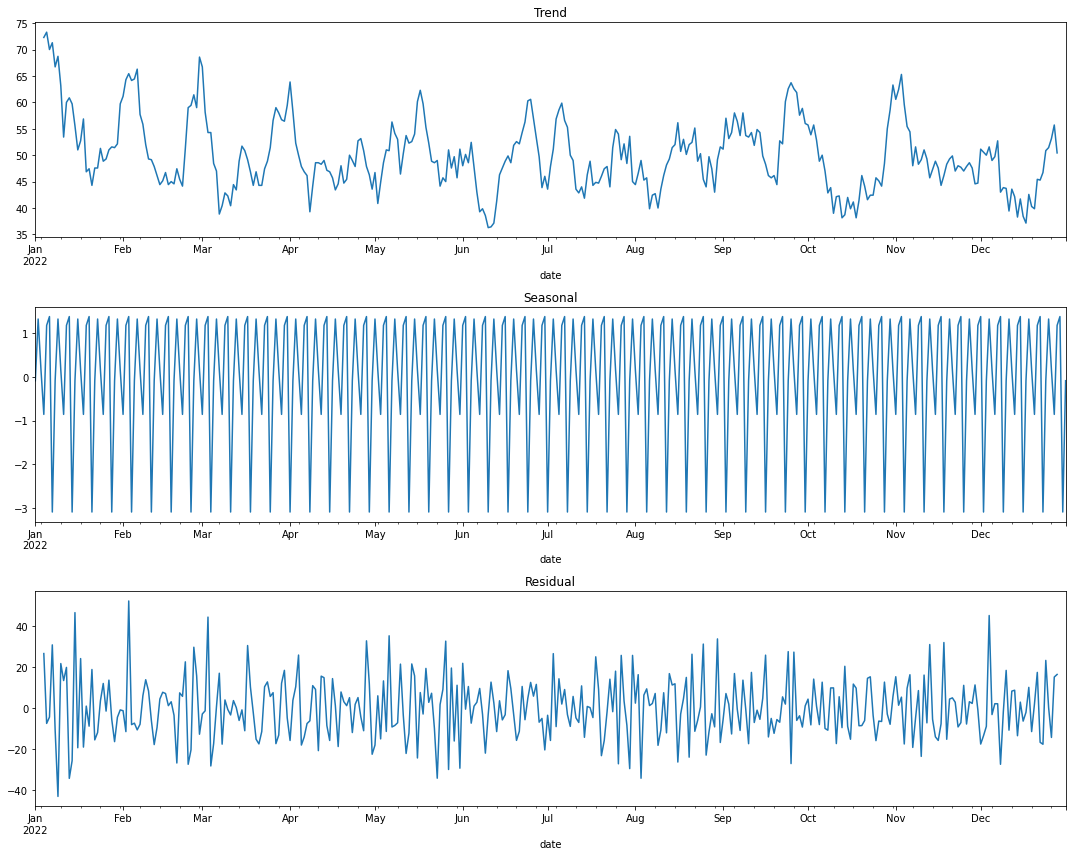

In [166]:
decompose = seasonal_decompose(df_fore)

fig,ax = plt.subplots(3,1,figsize=(15,12))
decompose.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decompose.seasonal.plot(ax=ax[1])
ax[1].set_title('Seasonal')
decompose.resid.plot(ax=ax[2])
ax[2].set_title('Residual')

plt.tight_layout()
plt.show()

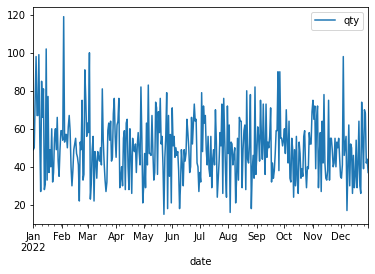

In [167]:
df_fore.plot()
plt.show()

## Trasnform data

In [168]:
#Transform data to log
df_fore = np.log(df_fore)
df_fore.head(3)

,qty
date,
2022-01-01,3.891820
2022-01-02,3.912023
2022-01-03,4.330733


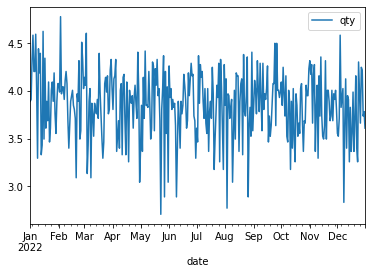

In [169]:
df_fore.plot()
plt.show()

In [170]:
#Split train and test
df_train = df_fore.iloc[:-31]
df_test = df_fore.iloc[-31:]


## Check Data Stationary

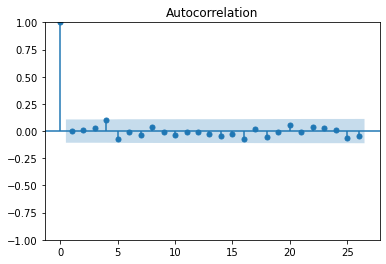

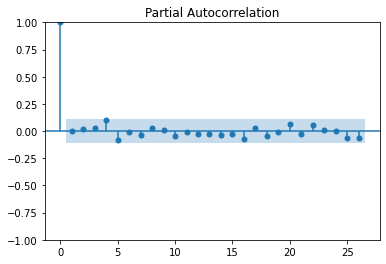

In [171]:
#ACF and PACF plot
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [172]:
#ADF test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 2.4374177848749832e-30


Dari ACF dan PACF plot dan ADF test data sudah statonary dan bisa digunakan untuk ARIMA model.

# Model ARIMA
Pada model arima dibutuhkan parameter (p,d,q) untuk menghasilkan forecast yang akurat. Dilakukan 2 metode untuk mendapatkan parameter ini yaitu dengan auto-fit arima dan manual parameter tuning

## Modelling & Evaluation

In [173]:
#auto-fit ARIMA
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [187]:
#Manual parameter tuning
def tune(z,y,x):
    model = ARIMA(df_train, order=(x,y,z))
    model_fit = model.fit()
    forecast_test = model_fit.forecast(len(df_test))
    df_plot = df_fore[['qty']].iloc[-61:]

    df_plot['forecast'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)
    
    mae = mean_absolute_error(df_test, forecast_test)
    mape = mean_absolute_percentage_error(df_test, forecast_test)
    rmse = np.sqrt(mean_squared_error(df_test, forecast_test))
    
    return mae,mape,rmse
    
#Parameter combinations
pval = [50,60,70]
dval = [2]
qval = [1]

comb = []
for i in pval:
    for j in dval:
        for k in qval:
            comb.append((i,j,k))

param = []
mae_score = []
mape_score = []
rmse_score = []

for i in comb:
    param.append(i)
    score = tune(*i)
    mae_score.append(score[0])
    mape_score.append(score[1])
    rmse_score.append(score[2])
    
tuning_df = pd.DataFrame({'param':param,'mae':mae_score,'mape':mape_score,'rsme':rmse_score})
tuning_df.sort_values(by='mae').head(3)

,param,mae,mape,rsme
2,"(70, 2, 1)",0.305765,0.081801,0.383388
1,"(60, 2, 1)",0.325634,0.086980,0.405777
0,"(50, 2, 1)",0.368164,0.100226,0.435390


In [188]:
#Manual parameter tuning
model = ARIMA(df_train, order=(70, 2, 1))
model_fit = model.fit()


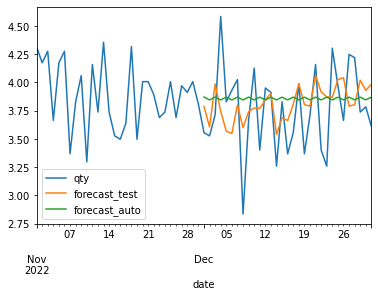

In [189]:
#plot forecasting
forecast_test = model_fit.forecast(len(df_test))
forecast_auto = auto_arima.predict(len(df_test))

df_plot = df_fore[['qty']].iloc[-61:]

df_plot['forecast_test'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

In [190]:
#Manual parameter tuning metrics

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 0.2978
mape - manual: 0.0813
rmse - manual: 0.3607


In [191]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(df_test, forecast_auto)
mape = mean_absolute_percentage_error(df_test, forecast_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 0.3039
mape - auto: 0.0846
rmse - auto: 0.378


Dari metric di atas kita pilih ARIMA model dengan parameters (70,2,1)

## Forecasting Overall Quantity

In [192]:
#Apply model to forecast data
model = ARIMA(df_fore, order=(70, 2, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

In [193]:
#Re-trasnform data
df_fore = np.exp(df_fore)
forecast = np.exp(forecast)

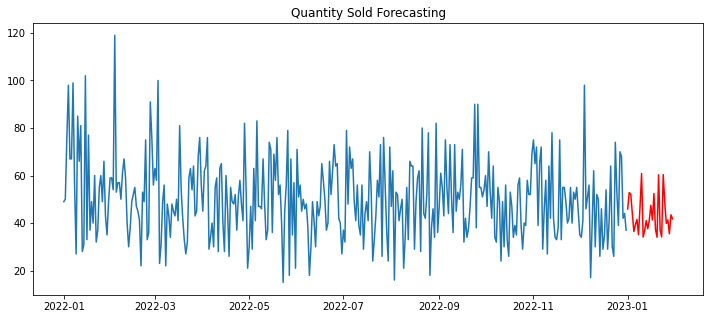

In [194]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_fore)
plt.plot(forecast,color='red')
plt.title('Quantity Sold Forecasting')
plt.show()

In [195]:
forecast.mean()

43.3640126525659

Dari forecasting di atas dapat disimpulkan bahwa untuk quantity penjualan bulan depan adalah sekitar rata-rata  43 pcs per harinya.

## Forecasting Each Product

In [196]:
#Forecast for next 30 days for each product
list_prod = df['product_name'].unique()

dfp = pd.DataFrame({'date':pd.date_range(start='2023-01-01',end='2023-01-30')})
dfp = dfp.set_index('date')
for i in list_prod:
    df_ = df[['date','product_name','qty']]
    df_ = df_[df_['product_name']==i]
    df_= df_.groupby('date')[['qty']].sum()
    df_ = df_.reset_index()

    df_t = pd.DataFrame({'date':pd.date_range(start='2022-01-01',end='2022-12-31')})
    df_t = df_t.merge(df_,how='left',on='date')
    df_t = df_t.fillna(0)
    df_t = df_t.set_index('date')

    model1 = ARIMA(df_t, order=(70, 2, 1))
    model_fit1 = model1.fit()
    forecast1 = model_fit1.forecast(steps=30)
    dfp[i] = forecast1.values
    
dfp.head()

,Crackers,Oat,Thai Tea,Choco Bar,Coffee Candy,Yoghurt,Ginger Candy,Cheese Stick,Cashew,Potato Chip
date,,,,,,,,,,
2023-01-01,4.803820,2.143729,6.119847,1.535068,4.657319,4.275114,3.739949,8.953012,1.726601,4.436110
2023-01-02,4.652234,3.388053,3.109989,4.150622,3.005288,4.371606,5.012358,1.357480,2.416165,4.236842
2023-01-03,3.733437,2.635370,9.035132,6.282627,5.023884,4.823018,5.143644,3.318889,2.745683,4.326831
2023-01-04,2.280883,2.632456,5.232018,4.677012,4.575744,5.640254,2.056842,8.897496,2.469244,4.825739
2023-01-05,3.869756,1.205515,4.825542,-5.242782,6.895236,3.364253,6.070519,5.684551,1.607539,3.224782


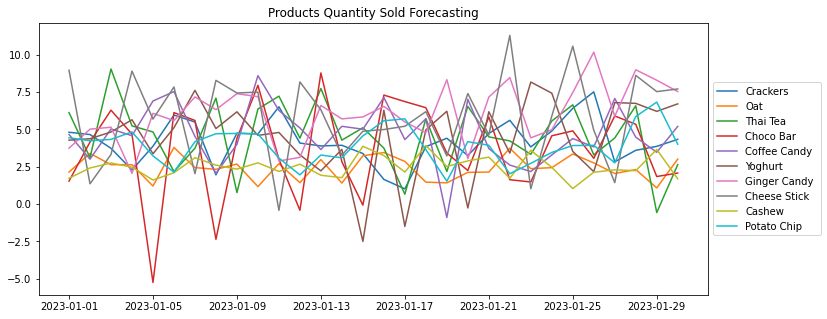

In [197]:
#Plot forecasting
plt.figure(figsize=(12,5))
# plt.plot(df_t)
plt.plot(dfp)
plt.legend(dfp.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Products Quantity Sold Forecasting')
plt.show()

In [198]:
#Products Quantity forecast
round(dfp.describe().T['mean'],0)

Crackers         4.0
Oat              2.0
Thai Tea         5.0
Choco Bar        4.0
Coffee Candy     5.0
Yoghurt          5.0
Ginger Candy     6.0
Cheese Stick     6.0
Cashew           2.0
Potato Chip      4.0
Name: mean, dtype: float64

Dari data forecasting product di atas kita bisa mendapatkan perkiraan rata-rata quantity produk yang terjual tiap harinya.

# Clustering data preparation

In [ ]:
df_clust = df.groupby('customerid').agg({'transactionid':'count','qty':'sum','totalamount':'sum'})
df_clust

In [ ]:
#Check outliers on new dataset
features = df_clust.columns
fig, ax = plt.subplots(1,len(df_clust.columns),figsize=(12,5))
for i in range(0,len(df_clust.columns)):
    sns.boxplot(data=df_clust,y=features[i],ax=ax[i])
plt.tight_layout()
plt.show()

Tidak terdapat outliers yang cukup kritis untuk di handling.

In [ ]:
#Standarisasi dataset baru
X = df_clust.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_clust.columns)
df_std.isna().sum()

# Model Clustering

## Elbow Method

In [ ]:
#Elbow method
inertia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(df_std.values)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.xticks(list(range(1,11)))
plt.plot(range(1,11),inertia,marker='o')
plt.title('Elbow Method')
plt.show()

Pada elbow method menunjukan cluster optimal pada n = 3

In [ ]:
# Kmeans n_cluster = 3
#Clustering Kmeans
kmeans_3 = KMeans(n_clusters=3,init='k-means++',max_iter=300,n_init=10,random_state=0)
kmeans_3.fit(X_std)

#Tambah clusters label pada dataset
df_cl3 = pd.DataFrame(data=X_std,columns=df_clust.columns)
df_cl3['cluster'] = kmeans_3.labels_
df_cl3.sample(3)

In [ ]:
#PLot Before PCA
plt.figure(figsize=(4,4))
sns.pairplot(data=df_cl3,hue='cluster',palette='Set1')
plt.show()

Dari diagram di atas clusters cukup terpisah secara sempurna.

In [ ]:
#PCA
pcs_3 = PCA(n_components=2).fit_transform(X_std)
pdf_3 = pd.DataFrame(data=pcs_3,columns=['pc1','pc2'])
pdf_3['cluster'] = df_cl3['cluster']
pdf_3.describe().T

In [ ]:
#PCA plot
fig,ax = plt.subplots(2,1,figsize=(10,8))
# plt.figure(figsize=(10,5))
sns.scatterplot(data=pdf_3,x='pc1',y='pc2',hue='cluster',palette='Set1',ax=ax[0])
ax[0].set_title('PCA scatter')
sns.kdeplot(data=pdf_3,x='pc1',hue='cluster',palette='Set1',fill=True,ax=ax[1])
ax[1].set_title('PCA kde')
plt.tight_layout()
plt.show()

## Sillhouette analysis

In [ ]:
n_clust = list(range(2,11))
silhouette_avg = []
for i in n_clust:
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    
    labels = kmeans.fit_predict(X_std)
    silhouette_avg.append(silhouette_score(X_std,labels))
    
plt.plot(n_clust,silhouette_avg)
plt.xlabel('n_clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for optimal n_clusters')
plt.show()

In [ ]:
range_n_clusters = [2,3, 4, 5,6]
X = X_std
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++',max_iter=300,n_init=10,random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Dari Silhouette analysis cluster dengan n = 3 terpisah dengan baik dengan silhouette coefficient 0.42.

# Cluster Analysis (RFM Analysis)

In [ ]:
df_clust['cluster'] = kmeans_3.labels_

df['recency'] = (pd.to_datetime('2023-01-01') - df_['date']).dt.days.astype('int')
df_r = df.groupby('customerid').agg({'recency':'min'})

df_rfm = df_clust.copy()
df_rfm['recency'] = df_r['recency']

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
sns.histplot(data=df_rfm,x='recency',hue='cluster',palette='Set1',ax=ax[0],kde=True)
ax[0].set_title('Recency')
sns.histplot(data=df_rfm,x='transactionid',hue='cluster',palette='Set1',ax=ax[1],kde=True)
ax[1].set_title('Frequency')
sns.histplot(data=df_rfm,x='totalamount',hue='cluster',palette='Set1',ax=ax[2],kde=True)
ax[2].set_title('Monetary')

plt.tight_layout()
plt.show()

Customer cluster charcteristic :
- Cluster 0 (New Customer):
    - Mostly having higher recency
    - Have Lowest Frequency and Monetary
    * Strategies :
        - Provide support
        - Gift discount
        - Build Relationship
- Cluster 1 (Potential Loyalist):
    - Have medium recency
    - Have  Highest Frequency and Monetary
    * Strategies :
        - Offer loyalty program
        - Run contest
        - Make them feel special
- Cluster 2 (Loyal Customer):
    - Have Highest low recency
    - Have Medium Frequency and Monetary
    * Strategies :
        - Take feedback and surveys
        - Upsell product
        - Present bonus